#### Implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers,regularizers,metrics
#Load data
data=pd.read_csv("datasets/creditcard.csv")
data.head(3)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284818 entries, 0 to 284817
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284818 non-null  float64
 8   V8      284818 non-null  float64
 9   V9      284818 non-null  float64
 10  V10     284818 non-null  float64
 11  V11     284818 non-null  float64
 12  V12     284818 non-null  float64
 13  V13     284818 non-null  float64
 14  V14     284818 non-null  float64
 15  V15     284818 non-null  float64
 16  V16     284818 non-null  float64
 17  V17     284818 non-null  float64
 18  V18     284818 non-null  float64
 19  V19     284818 non-null  float64
 20  V20     284818 non-null  float64
 21  V21     28

In [3]:
data.isnull().sum().max()

11

In [4]:
# Handling missing data
def fill_na(data):
    for col in data.columns:
        most_frequent_value = data[col].mode().iloc[0] 
        data[col].fillna(most_frequent_value, inplace=True)
    return data

data=fill_na(data)
data.isnull().sum().max()

0

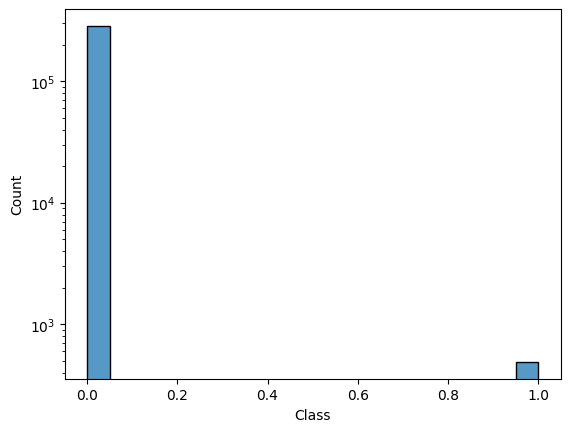

In [5]:
sns.histplot(data['Class'])
plt.yscale('log')
plt.show()

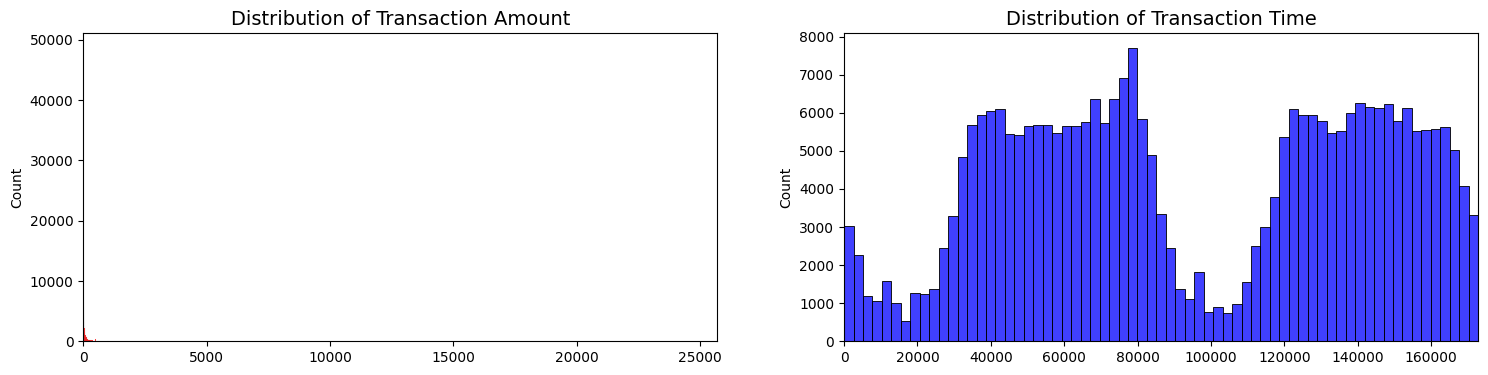

In [6]:
# checking the distribution of time and amount
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['Amount'].values
time_val = data['Time'].values

sns.histplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.histplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [7]:
# Scale the 'Amount' and 'Time' columns
rob_scaler = RobustScaler()
data[['Amount', 'Time']] = rob_scaler.fit_transform(data[['Amount', 'Time']])
data.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.995013,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.782402,0
1,-0.995013,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269693,0


Class
1    0.5
0    0.5
Name: count, dtype: float64


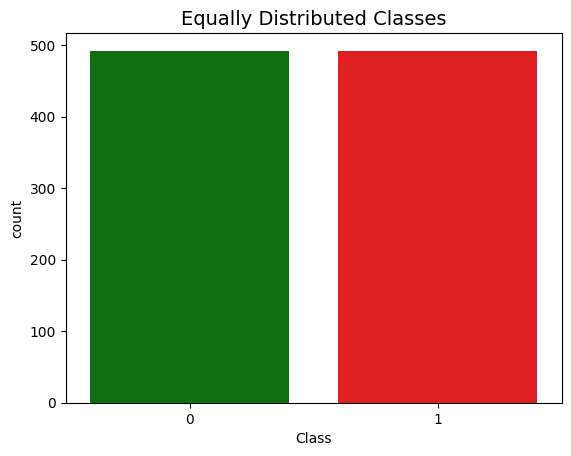

In [8]:
# Random Under sampling
fraud_count=len(data[data.Class==1].index)
fraud_idx=np.array(data[data.Class==1].index)
normal_idx= np.array(data[data.Class==0].index)

#randomly choosing normal indexes equal to fraud counts
random_normal_idx=np.random.choice(normal_idx,fraud_count,replace=False)
# undersampling
under_sample_idx=np.concatenate([fraud_idx,random_normal_idx])
# under sampled data
under_sample_data=data.iloc[under_sample_idx,:]
under_sample_data = under_sample_data.sample(frac=1, random_state=0).reset_index(drop=True)
#undersampled
X_us=under_sample_data.drop('Class',axis=1)
y_us=under_sample_data['Class']

print(under_sample_data['Class'].value_counts()/len(under_sample_data))
colors=['green','red']
sns.countplot(x='Class', data=under_sample_data, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

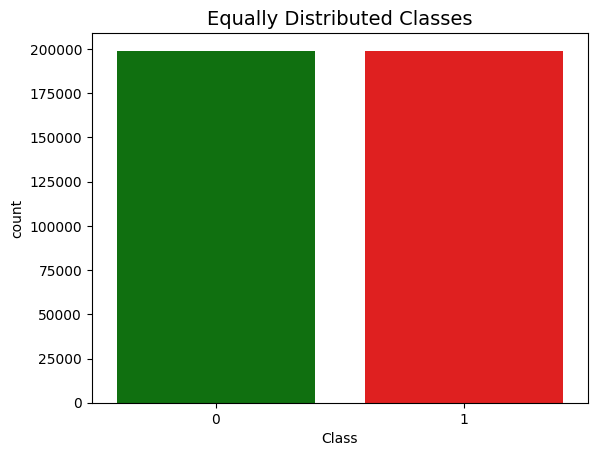

(25634, 30)

In [108]:
#original
X=data.drop('Class',axis=1)
y=data['Class']
X_train,X_temp,y_train,y_temp=train_test_split(X,y,test_size=.3,random_state=0,stratify=y)
X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,test_size=.3,random_state=0,stratify=y_temp)
# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# calss distribution
class_distribution = y_train_smote.value_counts() / len(y_train_smote)
# Plotting 
colors = ['green', 'red']
sns.countplot(x=y_train_smote, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

X_val.shape

In [10]:
# Convert the df into arrays
#oversampled df
X_train_smote=X_train_smote.values
y_train_smote=y_train_smote.values
# original df
X_val=X_val.values
y_val=y_val.values
X_test=X_test.values
y_test=y_test.values
#under sampled df
X_us=X_us.values
y_us=y_us.values

In [11]:
# Function to create the model
def create_model(learning_rate=0.01, dropout_rate=0.2, l2_reg=0.01):
    model = keras.Sequential([
        keras.Input(shape=(X.shape[-1])),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(1)
    ])
   
    model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        
         metrics = [
                    'accuracy',
                    metrics.FalseNegatives(name="fn"),
                    metrics.FalsePositives(name="fp"),
                    metrics.TrueNegatives(name="tn"),
                    metrics.TruePositives(name="tp"),
                    metrics.Precision(name="precision"),
                    metrics.Recall(name="recall"),
                    ]
    )

    return model

# Create KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.01,dropout_rate=0.2, l2_reg=0.01,verbose=2)

# Hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.001],
    'dropout_rate': [0.2, 0.5],
    'l2_reg': [0.01, 0.001],
}

# Learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(
    monitor="loss", factor=0.1, patience=5, mode="max", verbose=1
)

# Early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)


In [12]:
# Fit to smote data
grid_result = grid.fit(X_train_smote, y_train_smote, epochs=60, batch_size=64,verbose=2, callbacks=[lr_scheduler, es])

# Print best parameters
print("Best Parameters SMOTE: ", grid_result.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/60
4147/4147 - 6s - loss: 0.1760 - accuracy: 0.9497 - fn: 10425.0000 - fp: 2918.0000 - tn: 129767.0000 - tp: 122260.0000 - precision: 0.9767 - recall: 0.9214 - 6s/epoch - 2ms/step
Epoch 2/60
4147/4147 - 5s - loss: 0.1621 - accuracy: 0.9560 - fn: 7906.0000 - fp: 3772.0000 - tn: 128913.0000 - tp: 124779.0000 - precision: 0.9707 - recall: 0.9404 - 5s/epoch - 1ms/step
Epoch 3/60
4147/4147 - 5s - loss: 0.1602 - accuracy: 0.9597 - fn: 6416.0000 - fp: 4286.0000 - tn: 128399.0000 - tp: 126269.0000 - precision: 0.9672 - recall: 0.9516 - 5s/epoch - 1ms/step
Epoch 4/60
4147/4147 - 5s - loss: 0.1654 - accuracy: 0.9600 - fn: 5496.0000 - fp: 5112.0000 - tn: 127573.0000 - tp: 127189.0000 - precision: 0.9614 - recall: 0.9586 - 5s/epoch - 1ms/step
Epoch 5/60
4147/4147 - 5s - loss: 0.1637 - accuracy: 0.9605 - fn: 5378.0000 - fp: 5111.0000 - tn: 127574.0000 - tp: 127307.0000 - precision: 0.9614 - recall: 0.9595 - 5s/epoch - 1ms/step
Epoc

In [13]:
# Fit to undersampled data
grid_result_undersampled = grid.fit(X_us, y_us, epochs=60, batch_size=64,verbose=2, callbacks=[lr_scheduler, es])
# Print best parameters
print("Best Parameters Undersampled: ", grid_result_undersampled.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/60
11/11 - 1s - loss: 0.8693 - accuracy: 0.8521 - fn: 75.0000 - fp: 22.0000 - tn: 306.0000 - tp: 253.0000 - precision: 0.9200 - recall: 0.7713 - 1s/epoch - 132ms/step
Epoch 2/60
11/11 - 0s - loss: 0.5504 - accuracy: 0.9070 - fn: 54.0000 - fp: 7.0000 - tn: 321.0000 - tp: 274.0000 - precision: 0.9751 - recall: 0.8354 - 22ms/epoch - 2ms/step
Epoch 3/60
11/11 - 0s - loss: 0.4132 - accuracy: 0.9253 - fn: 46.0000 - fp: 3.0000 - tn: 325.0000 - tp: 282.0000 - precision: 0.9895 - recall: 0.8598 - 21ms/epoch - 2ms/step
Epoch 4/60
11/11 - 0s - loss: 0.3388 - accuracy: 0.9421 - fn: 29.0000 - fp: 9.0000 - tn: 319.0000 - tp: 299.0000 - precision: 0.9708 - recall: 0.9116 - 22ms/epoch - 2ms/step
Epoch 5/60
11/11 - 0s - loss: 0.2850 - accuracy: 0.9390 - fn: 32.0000 - fp: 8.0000 - tn: 320.0000 - tp: 296.0000 - precision: 0.9737 - recall: 0.9024 - 21ms/epoch - 2ms/step
Epoch 6/60
11/11 - 0s - loss: 0.2466 - accuracy: 0.9421 - fn: 30.0000

In [14]:
# SMOTE new model
best_hp_smote=grid_result.best_params_
best_model_smote=create_model(**best_hp_smote)
best_model_smote.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 32)                992       
                                                                 
 dropout_100 (Dropout)       (None, 32)                0         
                                                                 
 dense_151 (Dense)           (None, 16)                528       
                                                                 
 dropout_101 (Dropout)       (None, 16)                0         
                                                                 
 dense_152 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# undersampled new model
best_hp_undersampled=grid_result_undersampled.best_params_
best_model_undersampled=create_model(**best_hp_undersampled)
best_model_undersampled.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 32)                992       
                                                                 
 dropout_102 (Dropout)       (None, 32)                0         
                                                                 
 dense_154 (Dense)           (None, 16)                528       
                                                                 
 dropout_103 (Dropout)       (None, 16)                0         
                                                                 
 dense_155 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Fit the best smote model on train(SMOTE) data
history_smote=best_model_smote.fit(X_train_smote,y_train_smote,batch_size=64,epochs=70,validation_data=(X_val,y_val),callbacks=[lr_scheduler,es],verbose=2)

Epoch 1/70
6220/6220 - 10s - loss: 0.1845 - accuracy: 0.9532 - fn: 15760.0000 - fp: 2853.0000 - tn: 196175.0000 - tp: 183268.0000 - precision: 0.9847 - recall: 0.9208 - val_loss: 0.0885 - val_accuracy: 0.9942 - val_fn: 4.0000 - val_fp: 145.0000 - val_tn: 25445.0000 - val_tp: 40.0000 - val_precision: 0.2162 - val_recall: 0.9091 - lr: 0.0010 - 10s/epoch - 2ms/step
Epoch 2/70
6220/6220 - 8s - loss: 0.0969 - accuracy: 0.9765 - fn: 7289.0000 - fp: 2082.0000 - tn: 196946.0000 - tp: 191739.0000 - precision: 0.9893 - recall: 0.9634 - val_loss: 0.0659 - val_accuracy: 0.9951 - val_fn: 4.0000 - val_fp: 122.0000 - val_tn: 25468.0000 - val_tp: 40.0000 - val_precision: 0.2469 - val_recall: 0.9091 - lr: 0.0010 - 8s/epoch - 1ms/step
Epoch 3/70
6220/6220 - 8s - loss: 0.0749 - accuracy: 0.9860 - fn: 3768.0000 - fp: 1815.0000 - tn: 197213.0000 - tp: 195260.0000 - precision: 0.9908 - recall: 0.9811 - val_loss: 0.0536 - val_accuracy: 0.9963 - val_fn: 4.0000 - val_fp: 91.0000 - val_tn: 25499.0000 - val_tp: 

In [17]:
#fit the best undersampled model on undersamled data
history_undersampled=best_model_undersampled.fit(X_us,y_us,batch_size=64,epochs=70,validation_data=(X_val,y_val),callbacks=[lr_scheduler,es],verbose=2)

Epoch 1/70
16/16 - 2s - loss: 1.3665 - accuracy: 0.6616 - fn: 288.0000 - fp: 45.0000 - tn: 447.0000 - tp: 204.0000 - precision: 0.8193 - recall: 0.4146 - val_loss: 1.1204 - val_accuracy: 0.9525 - val_fn: 9.0000 - val_fp: 1208.0000 - val_tn: 24382.0000 - val_tp: 35.0000 - val_precision: 0.0282 - val_recall: 0.7955 - lr: 0.0010 - 2s/epoch - 128ms/step
Epoch 2/70
16/16 - 0s - loss: 1.0273 - accuracy: 0.7957 - fn: 144.0000 - fp: 57.0000 - tn: 435.0000 - tp: 348.0000 - precision: 0.8593 - recall: 0.7073 - val_loss: 1.1094 - val_accuracy: 0.9521 - val_fn: 4.0000 - val_fp: 1225.0000 - val_tn: 24365.0000 - val_tp: 40.0000 - val_precision: 0.0316 - val_recall: 0.9091 - lr: 0.0010 - 458ms/epoch - 29ms/step
Epoch 3/70
16/16 - 0s - loss: 0.9435 - accuracy: 0.8445 - fn: 110.0000 - fp: 43.0000 - tn: 449.0000 - tp: 382.0000 - precision: 0.8988 - recall: 0.7764 - val_loss: 1.0529 - val_accuracy: 0.9650 - val_fn: 3.0000 - val_fp: 895.0000 - val_tn: 24695.0000 - val_tp: 41.0000 - val_precision: 0.0438 -

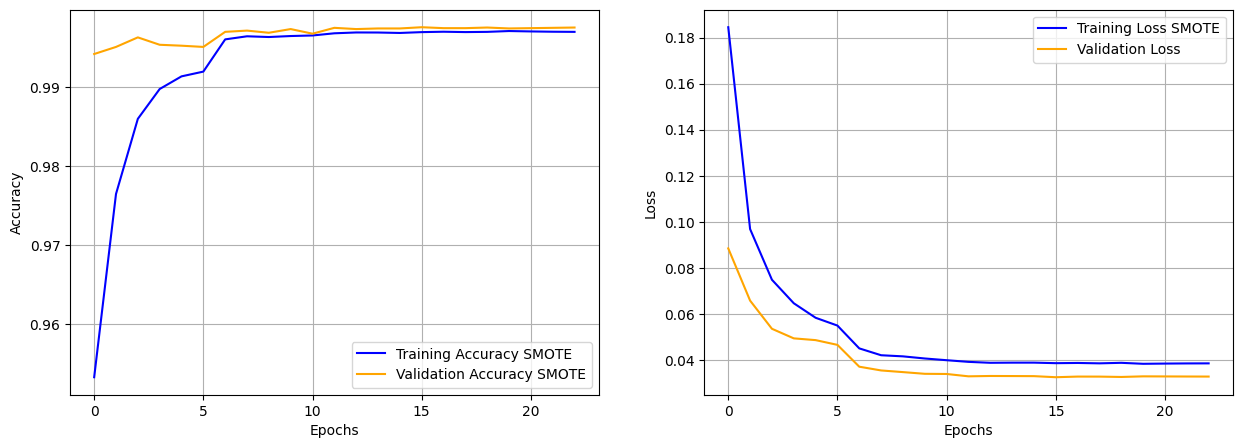

In [18]:
# Plotting the accuracies and losses for SMOTE data
accs_smote, val_accs_smote=history_smote.history['accuracy'],history_smote.history['val_accuracy']
losses_smote, val_losses_smote = history_smote.history['loss'],history_smote.history['val_loss']
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Training and Validation Accuracy
axs[0].plot(accs_smote, label='Training Accuracy SMOTE', color='blue')
axs[0].plot(val_accs_smote, label='Validation Accuracy SMOTE', color='orange')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot Training and Validation Loss
axs[1].plot(losses_smote, label='Training Loss SMOTE', color='blue')
axs[1].plot(val_losses_smote, label='Validation Loss', color='orange')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.show()

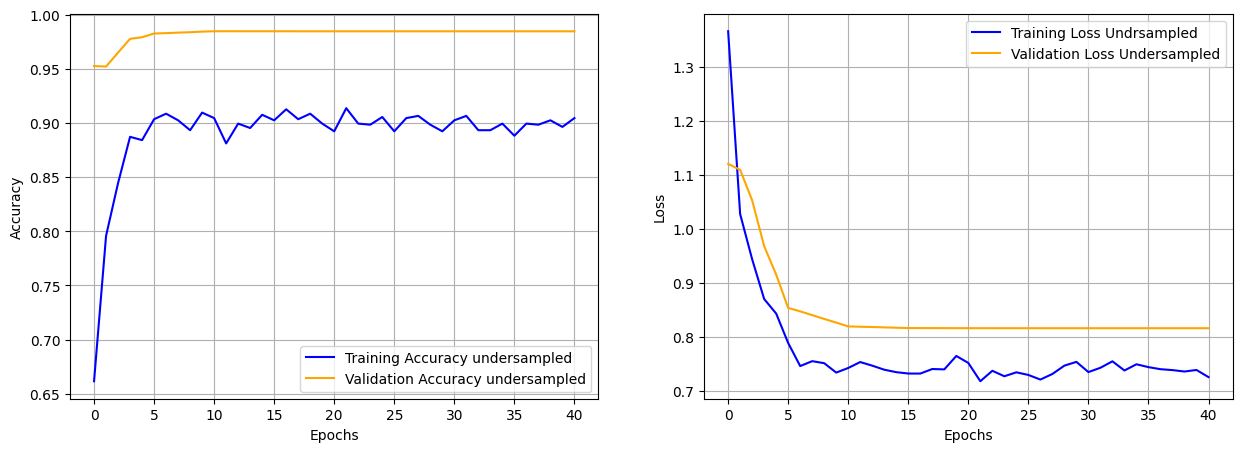

In [19]:
# Plotting the accuracies and losses for undersampled data
accs_undersampled, val_accs_undersampled=history_undersampled.history['accuracy'],history_undersampled.history['val_accuracy']
losses_undersampled, val_losses_undersampled = history_undersampled.history['loss'],history_undersampled.history['val_loss']
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Training and Validation Accuracy
axs[0].plot(accs_undersampled, label='Training Accuracy undersampled', color='blue')
axs[0].plot(val_accs_undersampled, label='Validation Accuracy undersampled', color='orange')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot Training and Validation Loss
axs[1].plot(losses_undersampled, label='Training Loss Undrsampled', color='blue')
axs[1].plot(val_losses_undersampled, label='Validation Loss Undersampled', color='orange')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.show()

**Note**: Although the validation accuracy is higher, the validation loss is higher than the training loss. It looks ironic from the perspective of machine learning. However, this happens because the amount of train data(undersampled=948) is far less than the validation data(25634).

In [20]:
# Evaluate smote model
evaluation_smote=best_model_smote.evaluate(X_test,y_test,batch_size=64,verbose=2)

935/935 - 1s - loss: 0.0329 - accuracy: 0.9973 - fn: 17.0000 - fp: 145.0000 - tn: 59563.0000 - tp: 87.0000 - precision: 0.3750 - recall: 0.8365 - 907ms/epoch - 970us/step


In [21]:
# Evaluate undersampled model
evaluation_undersampled=best_model_undersampled.evaluate(X_test,y_test,batch_size=64,verbose=2)

935/935 - 1s - loss: 0.8164 - accuracy: 0.9843 - fn: 14.0000 - fp: 925.0000 - tn: 58783.0000 - tp: 90.0000 - precision: 0.0887 - recall: 0.8654 - 893ms/epoch - 955us/step


In [22]:
# f1 score calculation
def f1_score(x,y):
    return 2*x*y/(x+y)

precision_smote= evaluation_smote[6]
recall_smote=evaluation_smote[7]

precision_undersampled= evaluation_undersampled[6]
recall_undersampled=evaluation_undersampled[7]

f1_smote=f1_score(precision_smote,recall_smote)
f1_undersampled=f1_score(precision_undersampled,recall_undersampled)

print(f"f1 score for smote: {f1_smote}\nf1score for undersampled: {f1_undersampled}")

f1 score for smote: 0.5178571375859837
f1score for undersampled: 0.16085790519681037


1870/1870 [==============================] - 2s 1ms/step


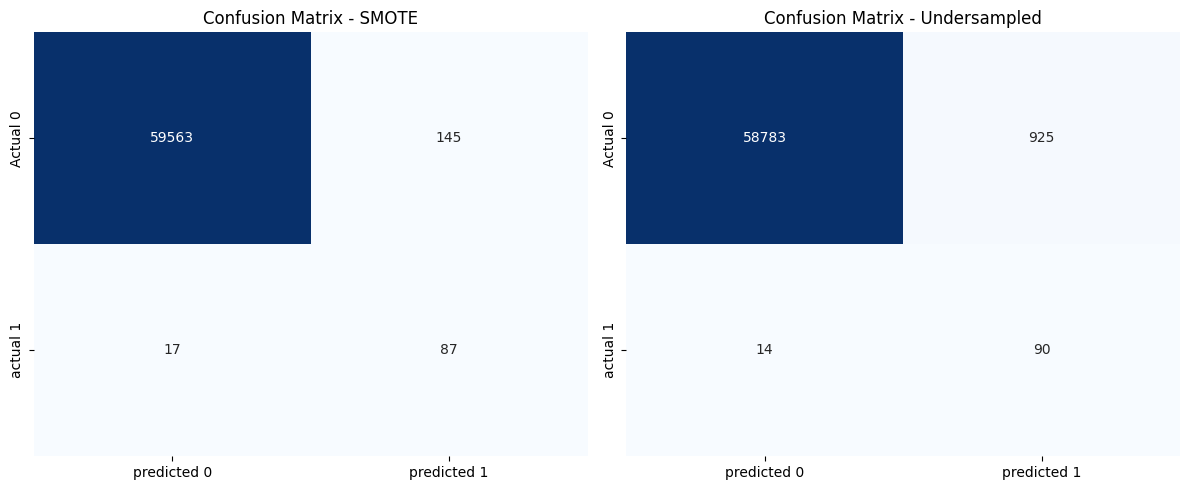

In [27]:

# confusin matrix
y_pred_prob_smote = best_model_smote.predict(X_test)
y_pred_smote = (y_pred_prob_smote > 0.5).astype(int) 

y_pred_prob_undersampled = best_model_undersampled.predict(X_test)
y_pred_undersampled = (y_pred_prob_undersampled > 0.5).astype(int) 

# Calculate confusion matrix
cm_smote= confusion_matrix(y_test, y_pred_smote)
cm_undersampled= confusion_matrix(y_test, y_pred_undersampled)


plt.figure(figsize=(12, 5))

# Confusion Matrix for SMOTE
plt.subplot(1, 2, 1)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['predicted 0', 'predicted 1'], yticklabels=['Actual 0', 'actual 1'])
plt.title('Confusion Matrix - SMOTE')

# Confusion Matrix for Undersampled
plt.subplot(1, 2, 2)
sns.heatmap(cm_undersampled, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['predicted 0', 'predicted 1'], yticklabels=['Actual 0', 'actual 1'])
plt.title('Confusion Matrix - Undersampled')
# plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

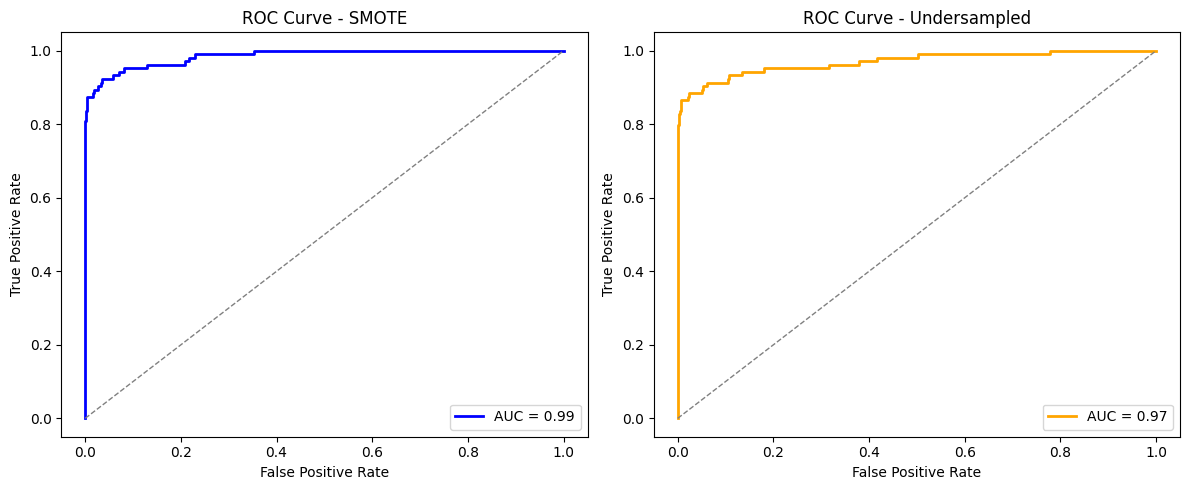

In [24]:

# Calculate ROC curve
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_pred_prob_smote)
fpr_undersampled, tpr_undersampled, thresholds_undersampled = roc_curve(y_test, y_pred_prob_undersampled)

# Calculate AUC (Area Under the Curve)
roc_auc_smote = auc(fpr_smote, tpr_smote)
roc_auc_undersampled = auc(fpr_undersampled, tpr_undersampled)


plt.figure(figsize=(12, 5))

# ROC Curve for SMOTE
plt.subplot(1, 2, 1)
plt.plot(fpr_smote, tpr_smote, color='blue', lw=2, label=f'AUC = {roc_auc_smote:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SMOTE')
plt.legend(loc='lower right')

# ROC Curve for Undersampled
plt.subplot(1, 2, 2)
plt.plot(fpr_undersampled, tpr_undersampled, color='orange', lw=2, label=f'AUC = {roc_auc_undersampled:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Undersampled')
plt.legend(loc='lower right')
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

PermutationExplainer explainer: 59813it [33:10, 29.91it/s]                           


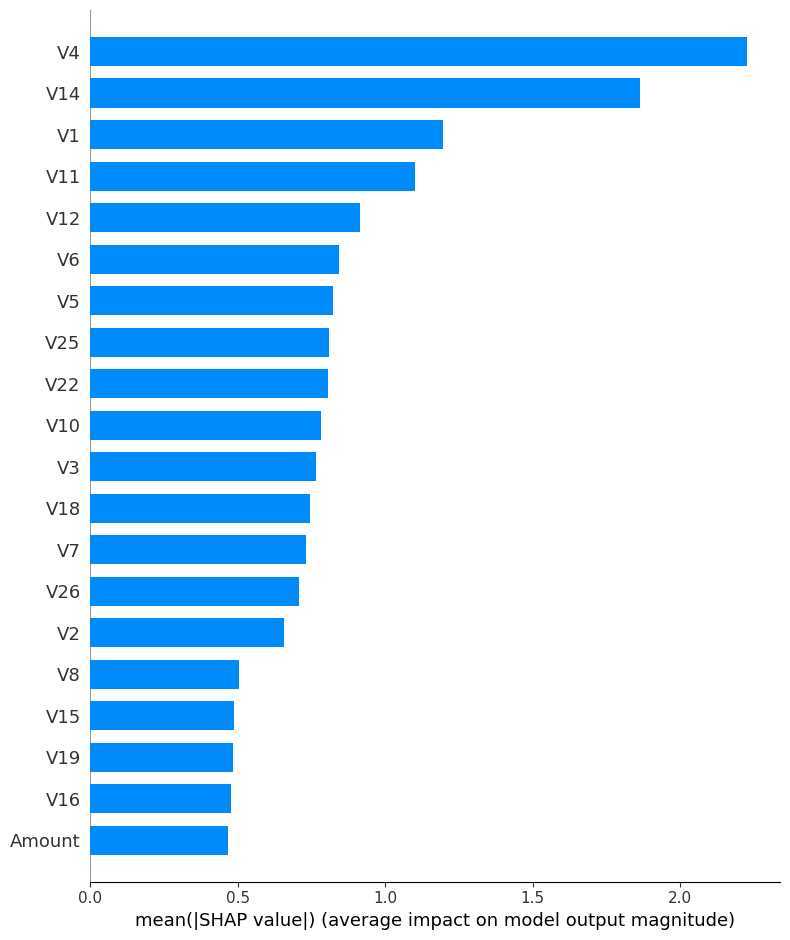

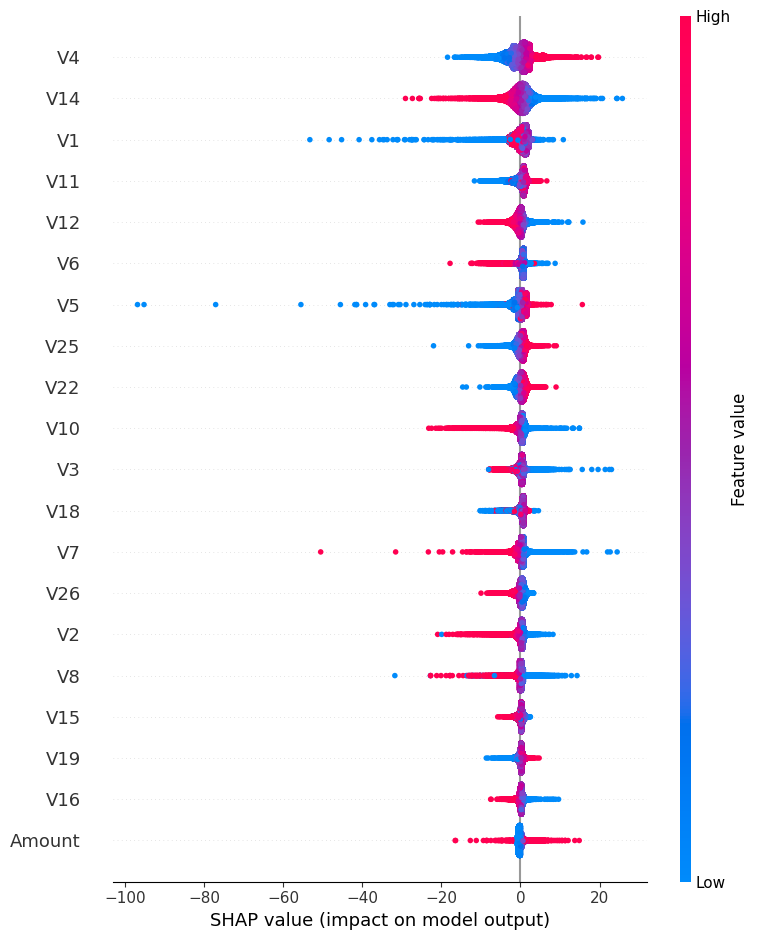

In [107]:
import shap

def explain_model_decisions_shap(model, data, feature_names=None):
    explainer = shap.Explainer(model, masker=shap.maskers.Independent(data))
    # Generate SHAP values for the data
    shap_values = explainer.shap_values(data)
    # Summary plot of feature importance for the entire dataset
    shap.summary_plot(shap_values, data, feature_names=feature_names, plot_type="bar")
    shap.summary_plot(shap_values, data, feature_names=feature_names)
    plt.show()

explain_model_decisions_shap(best_model_smote, X_test, data.columns.tolist())


Here in the first graphic, it is clearly shown which features have most impact on the model's output. However v4, v14, v1 are the first three features with the most predictive power. On the other hand v16, v19, Amount contribute less compared to other features.

A more granular overvies of the impact of each features to contribute in the prediction can be shown into the second graphic. The y-axis refers to average shap values for features while the x-axis represents the shap values. In this graphic for every sample shap value is mapped.


